# Comparing P-Median Variations

This tutorial compares 4 versions of the $p$-median problem.

***Authors***
* [Rongbo Xu](https://github.com/rongboxu)
* [Germano Barcelos](https://github.com/gegen07)
* [James Gaboardi](https://github.com/jGaboardi)
* [Levi J. Wolf](https://github.com/ljwolf)
* [Qunshan Zhao](https://github.com/qszhao)

***Contents***

1. Model data set up & inputs
2. The classic $p$-median problem
3. The capacited $p$-median problem
4. The $k$-nearest $p$-median problem
5. The capacited $k$-nearest $p$-median problem
6. Comparing variant results
7. References

***Notes***
* All models are solved with euclidean distance as impedence
* Detailed explanations of the classic $p$-median problem and the capacited variant can be found in [the p-median tutorial](p-median.ipynb). These models were included in `spopt` with [GSoC 2021](https://summerofcode.withgoogle.com/archive/2021/projects/5746198429827072) by [Germano Barcelos](https://github.com/gegen07) and [AGILE 2023](https://agile-giss.copernicus.org/articles/4/20/2023/) by [Rongbo Xu](https://github.com/rongboxu), respectively.
* The $k$-nearest $p$-median problem implementations were part of [GSoC 2023](https://summerofcode.withgoogle.com/programs/2023/projects/05jDO3IG) and contributed by [Rongbo Xu](https://github.com/rongboxu). The complete, detailed write-up can be found [here](https://github.com/rongboxu/P-Median-Model-with-Near-Far-Cost-Allocation/blob/main/notebooks/k_nearest_p_median_model.ipynb).

------------------

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2023-12-10T13:16:52.881916-05:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.18.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy
import pandas
import pulp
import shapely
import spopt
from matplotlib.patches import Patch
from spopt.locate import KNearestPMedian, PMedian, simulated_geo_points

%watermark -w
%watermark -iv

Watermark: 2.4.3

geopandas : 0.14.1
pandas    : 2.1.3
shapely   : 2.0.2
matplotlib: 3.8.2
spopt     : 0.5.1.dev53+g5cadae7
numpy     : 1.26.2
pulp      : 2.7.0



------------------------------------------------

## 1. Model data set up & inputs

### Constants

* `N_CLI`: The quantity of client locations to simulate
* `N_FAC`: The quantity of facility locations to simulate
* `P_FAC`: Candidate facilities in an optimal solution
* `SEED_CLI`/`SEED_FAC`: Random state seeds for reproducibility
* `solver`: The solver engine to utilize for optimization

In [3]:
N_CLI = 100
N_FAC = 100
P_FAC = 5
SEED_CLI = 7
SEED_FAC = 5
solver = pulp.COIN_CMD(msg=False, warmStart=True)


------------------


### Simulate client and candidate facility locations

The `simulated_geo_points` utility function available in `spopt` simulates points in a study area.

In [4]:
study_area = shapely.Polygon(((0,0), (10, 0), (10,10), (0, 10)))
clients = simulated_geo_points(study_area, needed=N_CLI, seed=SEED_CLI)
facilities = simulated_geo_points(study_area, needed=N_FAC, seed=SEED_FAC)
for df in [clients, facilities]:
    df.set_crs("EPSG:4326", inplace=True)

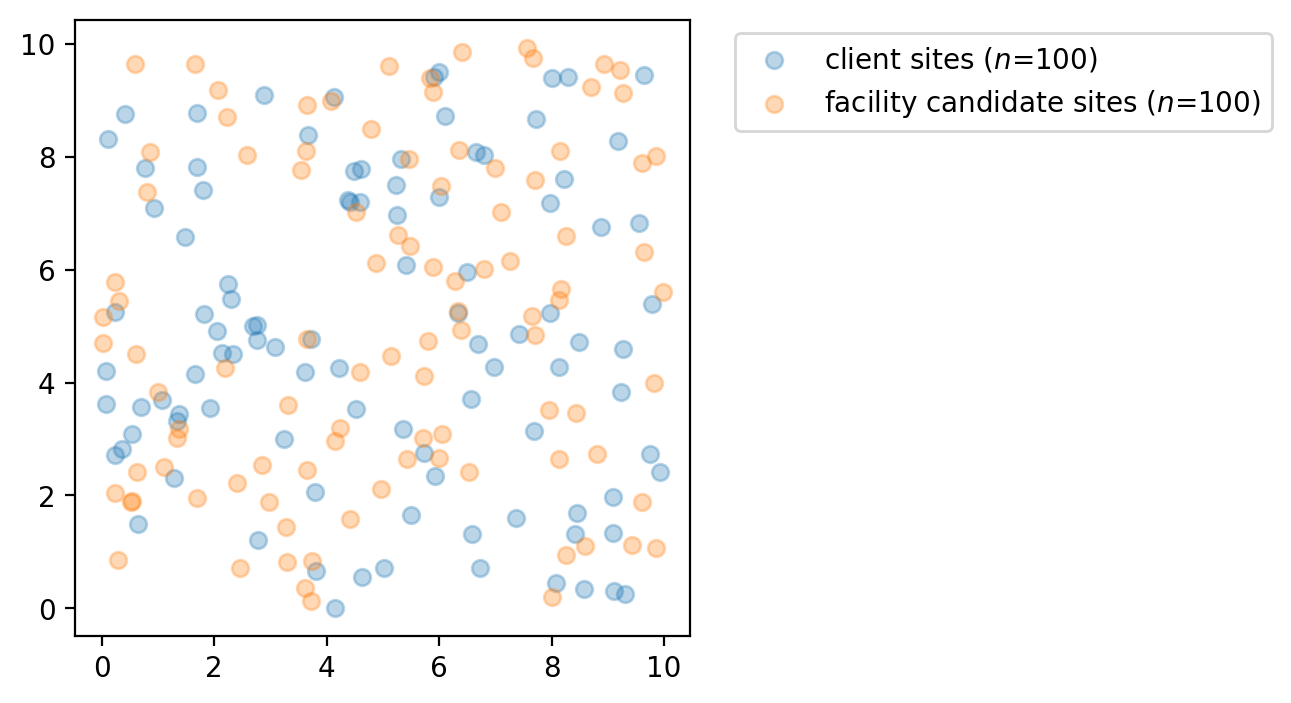

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
_label = f"client sites ($n$={N_CLI})"
clients.plot(ax=ax, label=_label, alpha=.3)
_label = f"facility candidate sites ($n$={N_FAC})"
facilities.plot(ax=ax, zorder=2, label=_label, alpha=.3)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

For each client location all $p$-median model varinates suppose there is a weight. Here we assign random integer values using `numpy` to simulate these weights ranging from a minimum of 1 and a maximum of 12.

In [6]:
numpy.random.seed(0)
ai = numpy.random.randint(1, 12, N_CLI)
clients["weights"] = ai
sum_clients = clients["weights"].sum()
print(f"The total of client weights: {sum_clients}")
clients

The total of client weights: 579


,geometry,weights
0,POINT (0.76308 7.79919),6
1,POINT (4.38409 7.23465),1
2,POINT (9.77990 5.38496),4
3,POINT (5.01120 0.72051),4
4,POINT (2.68439 4.99883),8
...,...,...
95,POINT (1.06877 3.69486),2
96,POINT (2.32671 4.51079),6
97,POINT (2.76317 5.01807),10
98,POINT (9.22603 3.82511),4


For each service facility the ***$p$-median capacitated variants*** suppose there is a service level available at each site (the capacity). Again, we assign random integer values using `numpy` to simulate these capacities ranging from a minimum of 25 and a maximum of 200.

In [7]:
min_cap = 25
max_cap = 200
numpy.random.seed(1)
cj = numpy.random.randint(min_cap, max_cap, N_FAC)
facilities["capacity"] = cj
sum_capacity = facilities["capacity"].sum()
print(f"The total of service capacity: {sum_capacity}")
facilities

The total of service capacity: 10654


,geometry,capacity
0,POINT (2.21993 8.70732),62
1,POINT (2.06719 9.18611),165
2,POINT (4.88411 6.11744),97
3,POINT (7.65908 5.18418),162
4,POINT (2.96801 1.87721),158
...,...,...
95,POINT (7.26789 6.15814),102
96,POINT (5.88500 6.05004),100
97,POINT (3.54785 7.77382),101
98,POINT (6.04603 3.09231),68


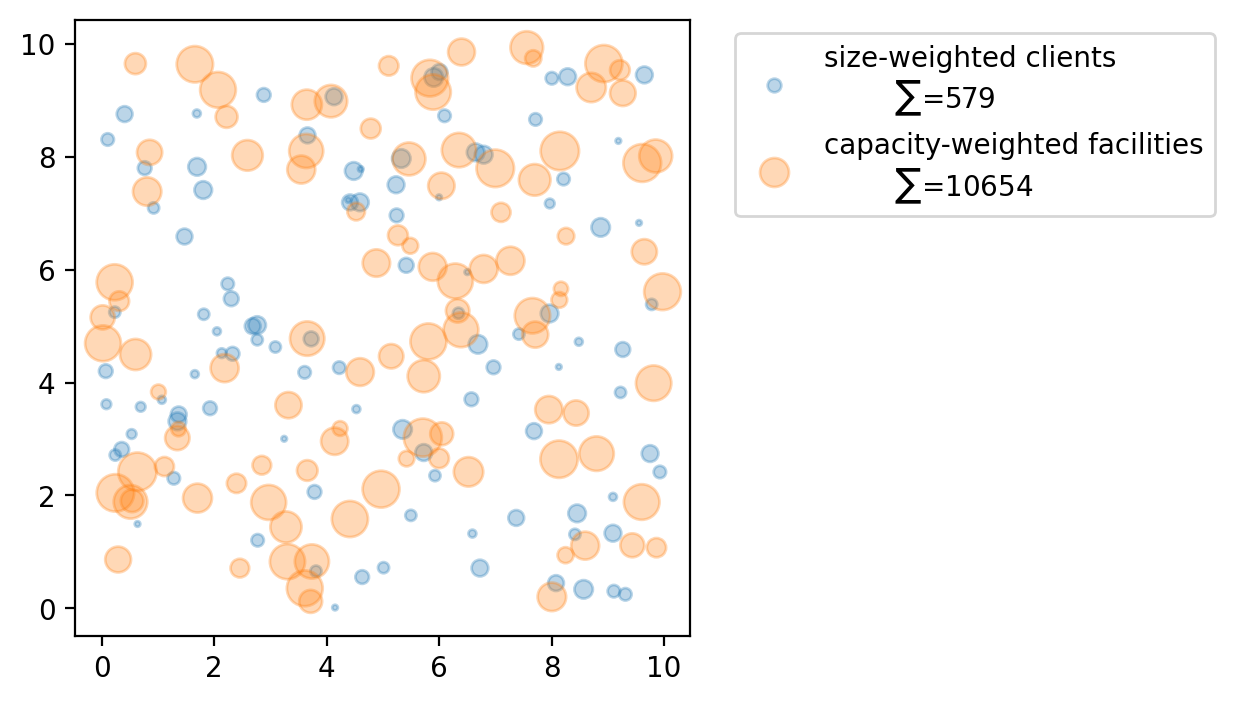

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
_label = f"size-weighted clients\n\t$\\sum$={sum_clients}"
clients.plot(ax=ax, label=_label, alpha=.3, markersize=ai*4)
_label = f"capacity-weighted facilities\n\t$\\sum$={sum_capacity}"
facilities.plot(ax=ax, label=_label, alpha=.3, markersize=cj)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));


---------------------------------------

##  2. The classic $p$-median problem

The $p$-median problem is a classic, introduced in [Hakimi (1965)](https://doi:10.1287/opre.13.3.462), seeks to minimize the maximum weights for siting $p$ facilities. As an integer linear program ($ILP$), the $p$-median problem is formulated as:

> $\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{j \in J}{a_i d_{ij} X_{ij}} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{j \in J}{X_{ij} = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (4) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (5) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (6) \\ \end{array}$

> $\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing client/demand locations} \\
& & j & \small = & \textrm{index referencing potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance between } i \textrm{ and } j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
\end{array}$

> _The formulation above is adapted from Church and Murray (2018)_


First, we declare model positional and keyword arguments, which will be used in all $p$-median problem variants.

In [9]:
model_args = clients, facilities, "geometry", "geometry", "weights", P_FAC

Instantiate and solve the classic $p$-median problem.

In [10]:
pmedian_classic = PMedian.from_geodataframe(*model_args, name="classic-p-median")
pmedian_classic = pmedian_classic.solve(solver)

Record decision variable names used for mapping later.

In [11]:
def fac_vars(pmp):
    return [f.name.replace("_", "") for f in pmp.fac_vars]

In [12]:
facilities["dv"] = fac_vars(pmedian_classic)
facilities = facilities[["geometry", "dv", "capacity"]].copy()
facilities

,geometry,dv,capacity
0,POINT (2.21993 8.70732),y0,62
1,POINT (2.06719 9.18611),y1,165
2,POINT (4.88411 6.11744),y2,97
3,POINT (7.65908 5.18418),y3,162
4,POINT (2.96801 1.87721),y4,158
...,...,...,...
95,POINT (7.26789 6.15814),y95,102
96,POINT (5.88500 6.05004),y96,100
97,POINT (3.54785 7.77382),y97,101
98,POINT (6.04603 3.09231),y98,68


Record solution diagnostics for model comparison.

In [13]:
def pmp_diagnostic(pmp, add_to=None):
    """Helper for displaying model diagnostics."""
    _diags = {
        "model": pmp.name,
        "variables": len(pmp.problem.variables()),
        "constraints": len(pmp.problem.constraints),
        "obj_val": round(pmp.problem.objective.value(), 3),
        "selected": [f.name.replace("_", "") for f in pmp.fac_vars if f.varValue],
        "cpu_time": pmp.problem.solutionCpuTime,
        "wall_time": pmp.problem.solutionTime,
    }
    _diags = pandas.DataFrame([_diags.values()], columns=_diags.keys())
    if isinstance(add_to, pandas.DataFrame):
        _diags = pandas.concat([add_to, _diags], ignore_index=True)
    return _diags

In [14]:
diagnostic = pmp_diagnostic(pmedian_classic)
diagnostic

,model,variables,constraints,obj_val,selected,cpu_time,wall_time
0,classic-p-median,10100,10101,906.299,"[y25, y32, y34, y68, y86]",0.510654,0.921897


The classic $p$-median problem does not take facility capacity into account, so we can (naively) assume that 100% of the capacity at each selected candidate facility is being utilized.

In [15]:
def cli_sum(f2c):
    return clients.loc[f2c, "weights"].sum()

def fac_cap(fdv):
    return facilities.loc[(facilities["dv"]==fdv), "capacity"].squeeze()

def serv_perc_cap(f2c, fdv):
    return round(cli_sum(f2c) / fac_cap(fdv), 2) * 100.0

def service_level(pmp):
    if pmp.name.startswith("capacitated"):
        zipped_vars = zip(pmp.fac2cli, facilities["dv"], strict=True)
        serv_lev = [serv_perc_cap(f2c, fdv) for f2c, fdv in zipped_vars]
    else:
        serv_lev = [100.0 if bool(dv.varValue) else 0. for dv in pmp.fac_vars]
    return serv_lev

In [16]:
facilities["pmp_classic"] = service_level(pmedian_classic)
perc_cols = [c for c in facilities.columns if c.startswith("pmp")]
facilities.loc[(facilities[perc_cols] > 0).any(axis=1)]

,geometry,dv,capacity,pmp_classic
25,POINT (7.70854 4.84931),y25,88,100.0
32,POINT (8.24811 0.94203),y32,33,100.0
34,POINT (5.46358 7.96143),y34,140,100.0
68,POINT (0.85070 8.07777),y68,82,100.0
86,POINT (2.18498 4.25637),y86,102,100.0


Plotting the results

In [17]:
dv_colors_arr = list(mcolors.CSS4_COLORS.keys())
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}

In [18]:
def plot_results(model, p, facs, clis=None):
    """Visualize optimal solution sets and context."""
    fig, ax = plt.subplots(figsize=(6, 6))
    markersize, markersize_factor = 4, 4
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting
    cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv = facs.loc[i, "dv"]
            fac_sites[dv] = i
            geom = clis.iloc[model.fac2cli[i]]["geometry"]
            cli_points[dv] = geom
    
    # study area and legend entries initialization
    legend_elements = []

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))
    
    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, fac in fac_sites.items():
        cset = dv_colors[fname]
        # clients
        geoms = cli_points[fname]
        gdf = geopandas.GeoDataFrame(geoms)
        gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
        _label = f"Demand sites covered by {fname}"
        _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
        legend_elements.append(
            mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
        )
        # facilities
        ec = "k"
        lw = 2
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        markersize -= markersize_factor / p
    
    # legend
    kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
    plt.legend(handles=legend_elements, **kws)

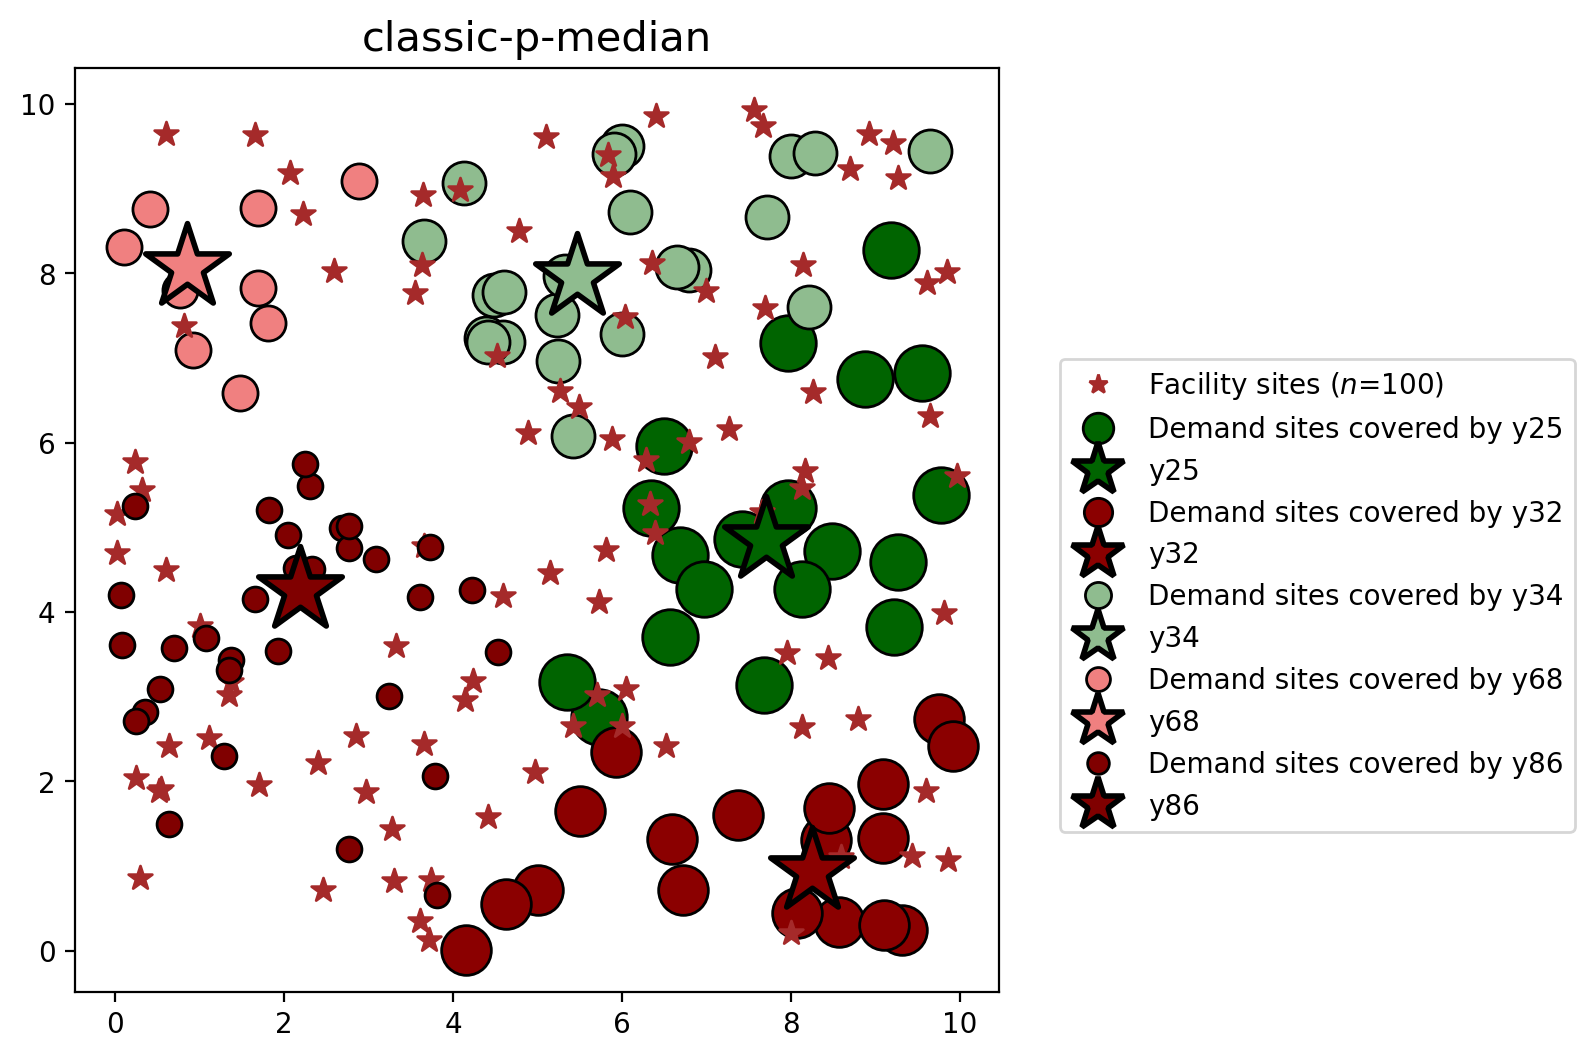

In [19]:
plot_results(pmedian_classic, P_FAC, facilities, clis=clients)

--------------------------------------


## 3. The capacited $p$-median problem


The capacitated variant of the $p$-median problem is formulated identically to the classic $p$-median problem with the addition of contraint $(4)$ below. Here constraint $(4)$ stipulates that for a facility to be considered for selection it must have the avaialable capacity to support demand from allocated client locations. The capacitated $p$-median variant can be formulated as:

>$\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{j \in J}{a_i d_{ij} X_{ij}} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{j \in J}{X_{ij} = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & \displaystyle \sum_{i \in I}{a_i X_{ij} \leq {c_j Y_{j}}}& \forall j \in J && (4) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (5) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (6) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (7) \\ \end{array}$

>$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing client/demand locations} \\
& & j & \small = & \textrm{index referencing potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance between } i \textrm{ and } j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & c_j & \small = & \textrm{capacity of facility } j \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
\end{array}$

>_The formulation above is adapted from Church and Murray (2009)_

In [20]:
pmedian_capacity = PMedian.from_geodataframe(
    *model_args, name="p-median", facility_capacity_col="capacity" 
)
pmedian_capacity = pmedian_capacity.solve(solver)

In [21]:
diagnostic = pmp_diagnostic(pmedian_capacity, add_to=diagnostic)
diagnostic

,model,variables,constraints,obj_val,selected,cpu_time,wall_time
0,classic-p-median,10100,10101,906.299,"[y25, y32, y34, y68, y86]",0.510654,0.921897
1,capacitated-p-median,10100,10201,962.151,"[y20, y30, y45, y73, y86]",11.699106,12.895250


In [22]:
facilities["pmp_capacitated"] = service_level(pmedian_capacity)
perc_cols = [c for c in facilities.columns if c.startswith("pmp")]
facilities.loc[(facilities[perc_cols] > 0).any(axis=1)]

,geometry,dv,capacity,pmp_classic,pmp_capacitated
20,POINT (2.59098 8.02497),y20,121,0.0,83.0
25,POINT (7.70854 4.84931),y25,88,100.0,0.0
30,POINT (6.35356 8.11902),y30,153,0.0,100.0
32,POINT (8.24811 0.94203),y32,33,100.0,0.0
34,POINT (5.46358 7.96143),y34,140,100.0,0.0
45,POINT (8.59707 1.11111),y45,101,0.0,95.0
68,POINT (0.85070 8.07777),y68,82,100.0,0.0
73,POINT (5.70975 3.02518),y73,187,0.0,68.0
86,POINT (2.18498 4.25637),y86,102,100.0,100.0


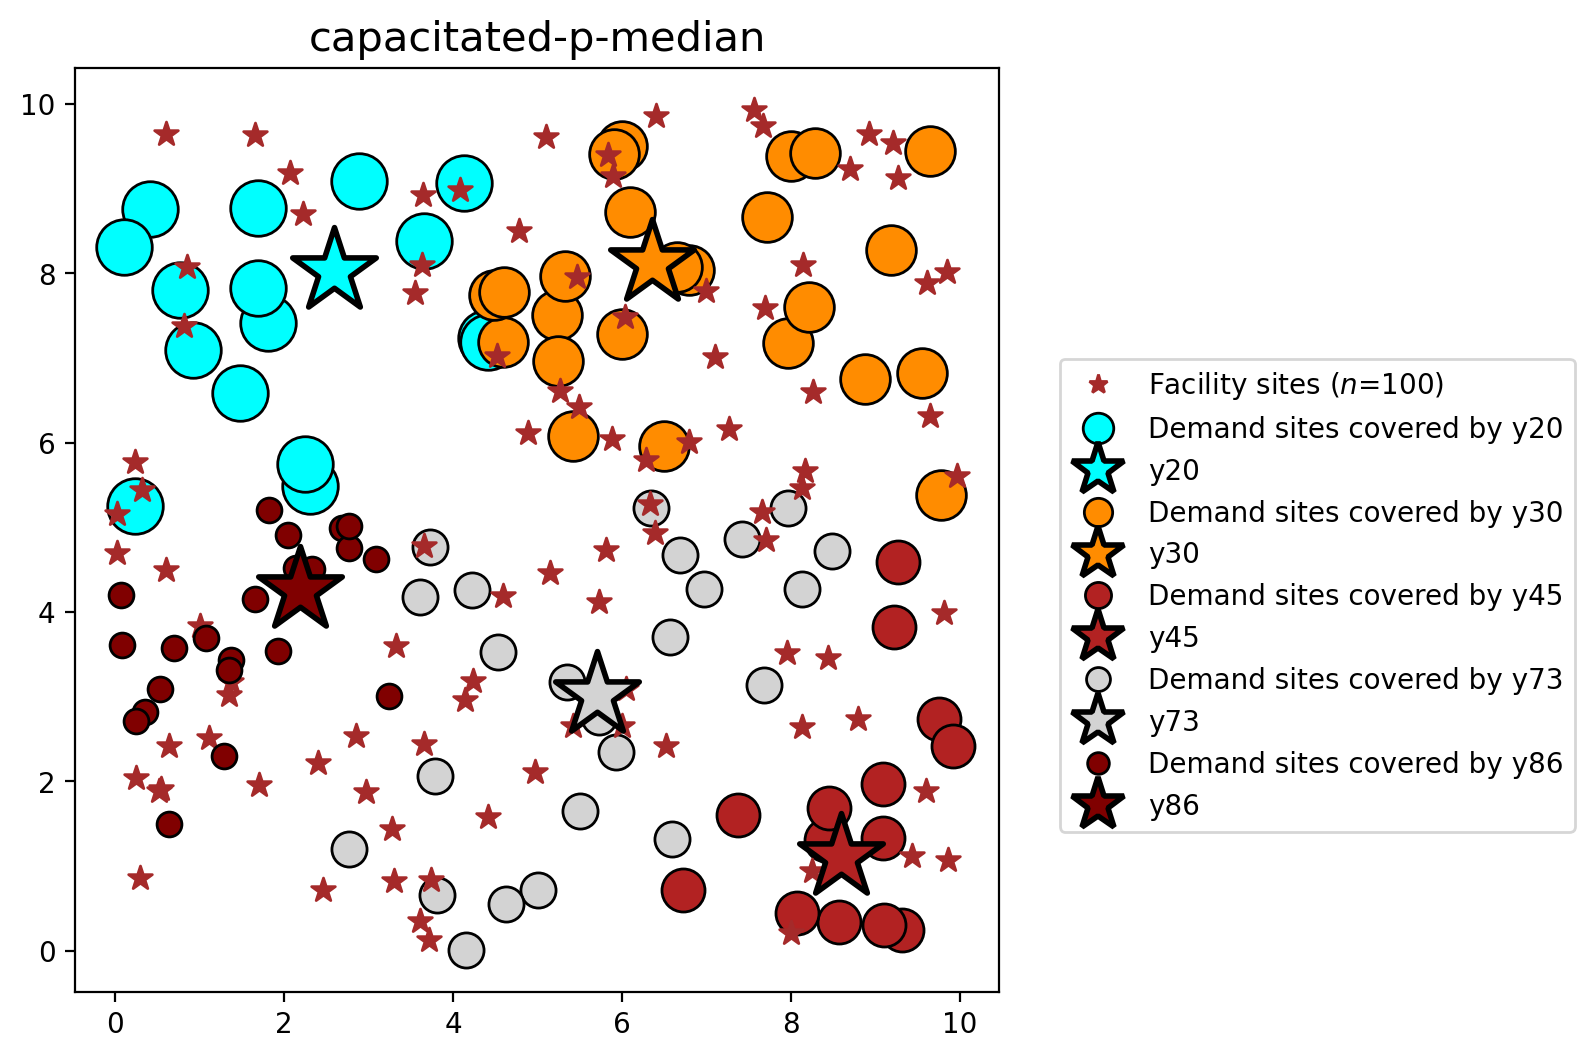

In [23]:
plot_results(pmedian_capacity, P_FAC, facilities, clis=clients)

--------------------------

## 4. The $k$-nearest $p$-median problem

The $k$-nearest $p$-median problem, also referred to as the $p$-median model with near-far cost allocation, implements a variant of the classic $p$-median problem that only considers a limited selection of the nearest facilites, and was introduced in [Church (2018)](https://doi.org/10.1177/0160017616650612). The focus here is the isolation a computationally efficient program for solving a $p$-median problem by dramatically reducing the number of variables and contraints in the mathematical formulation. As stated in the introduction above, a more detailed explanation of this model and its implementation can be found [here](https://github.com/rongboxu/P-Median-Model-with-Near-Far-Cost-Allocation/blob/main/notebooks/k_nearest_p_median_model.ipynb). The $k$-nearest $p$-median variant can be formulated as:

> $\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{k \in k_{i}}{a_i d_{ik} X_{ik}} + \sum_{i \in I}{g_i (d_{i{k_i}} + 1)} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{k \in k_{i}}{X_{ik} + g_i = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (4) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (5) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (6) \\ \end{array}$

> $\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing client/demand locations} \\
& & j & \small = & \textrm{index referencing potential facility sites} \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & k_i & \small = & \textrm{the } k \textrm{ nearest facilities of client location } i \\
& & c_j & \small = & \textrm{capacity of facility } j \\
& & d_{ij} & \small = & \textrm{shortest distance between } i \textrm{ and } j \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
& & g_{i} & \small = & \begin{cases}
             1, \textrm{if the client } i \textrm{ needs to be served by non-}k\textrm{-nearest facilities} \\
             0, \textrm{otherwise} \\
            \end{cases} \\ \end{array}$

> _The formulation above is adapted from Church (2018)_

In [24]:
pmedian_k_nearest = KNearestPMedian.from_geodataframe(
    *model_args, name="k-nearest-p-median",
)
pmedian_k_nearest = pmedian_k_nearest.solve(solver)

In [25]:
diagnostic = pmp_diagnostic(pmedian_k_nearest, add_to=diagnostic)
diagnostic

,model,variables,constraints,obj_val,selected,cpu_time,wall_time
0,classic-p-median,10100,10101,906.299,"[y25, y32, y34, y68, y86]",0.510654,0.921897
1,capacitated-p-median,10100,10201,962.151,"[y20, y30, y45, y73, y86]",11.699106,12.895250
2,k-nearest-p-median,1598,1499,906.299,"[y25, y32, y34, y68, y86]",0.064253,0.113859


In [26]:
facilities["pmp_k-nearest"] = service_level(pmedian_k_nearest)
perc_cols = [c for c in facilities.columns if c.startswith("pmp")]
facilities.loc[(facilities[perc_cols] > 0).any(axis=1)]

,geometry,dv,capacity,pmp_classic,pmp_capacitated,pmp_k-nearest
20,POINT (2.59098 8.02497),y20,121,0.0,83.0,0.0
25,POINT (7.70854 4.84931),y25,88,100.0,0.0,100.0
30,POINT (6.35356 8.11902),y30,153,0.0,100.0,0.0
32,POINT (8.24811 0.94203),y32,33,100.0,0.0,100.0
34,POINT (5.46358 7.96143),y34,140,100.0,0.0,100.0
45,POINT (8.59707 1.11111),y45,101,0.0,95.0,0.0
68,POINT (0.85070 8.07777),y68,82,100.0,0.0,100.0
73,POINT (5.70975 3.02518),y73,187,0.0,68.0,0.0
86,POINT (2.18498 4.25637),y86,102,100.0,100.0,100.0


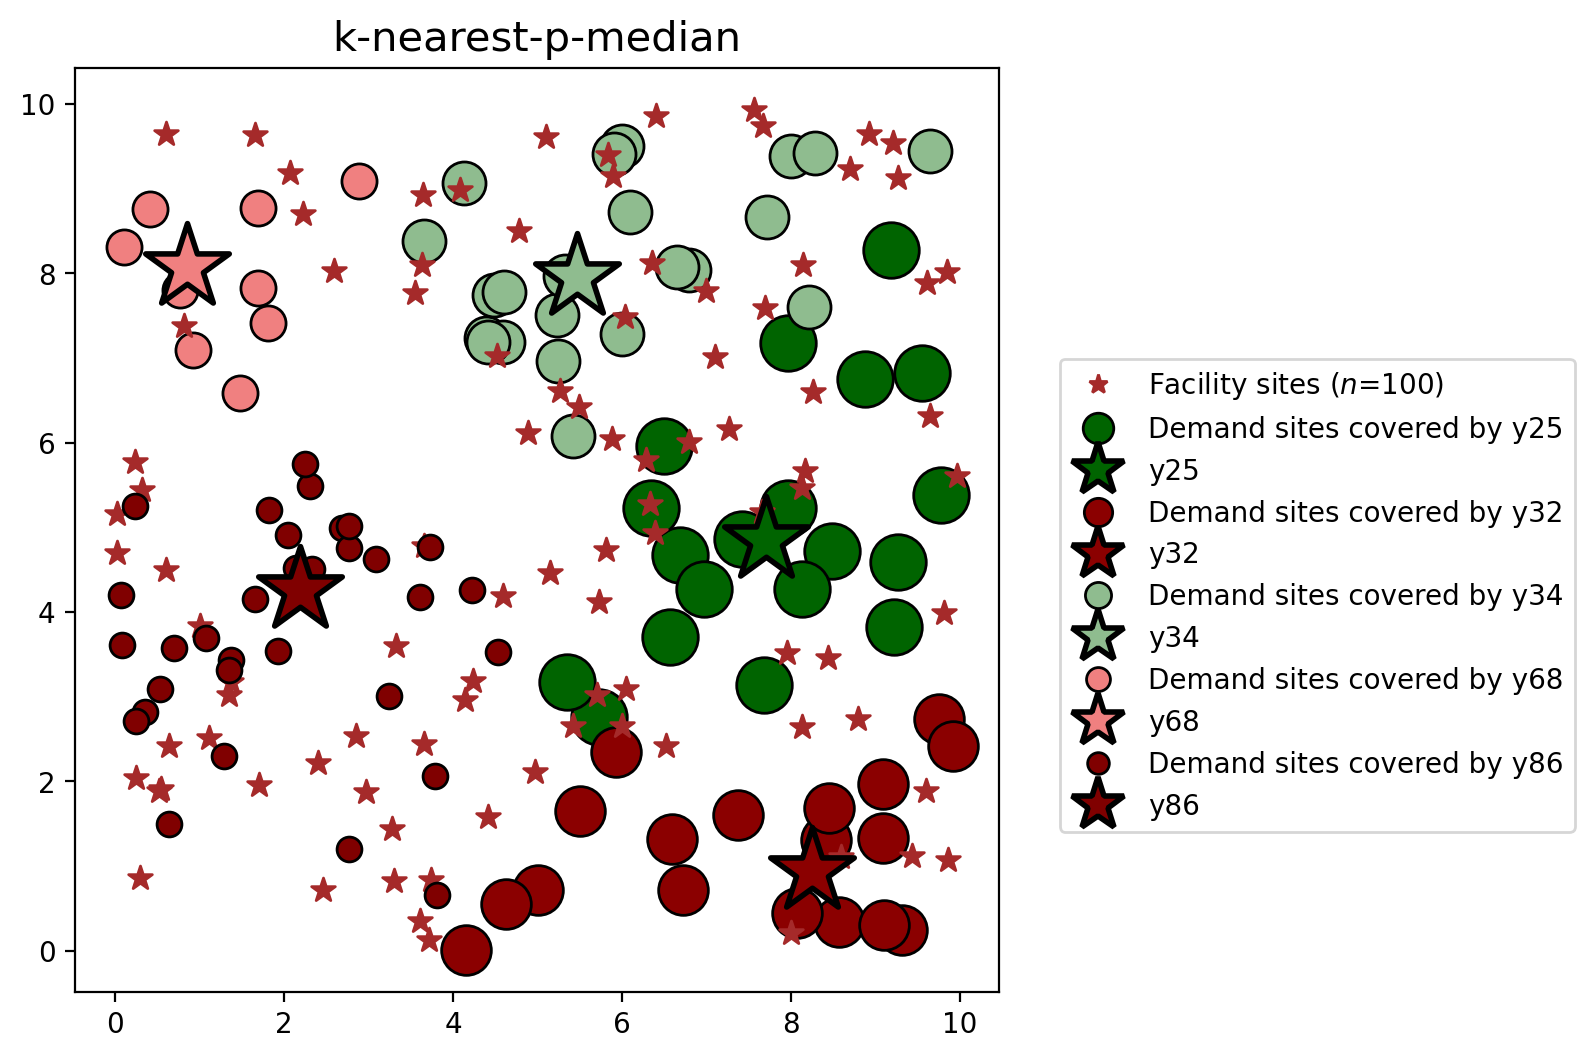

In [27]:
plot_results(pmedian_k_nearest, P_FAC, facilities, clis=clients)

--------------------------

## 5. The capacited $k$-nearest $p$-median problem

With the addition of equation $(4)$ below, we can also introduce facility capacity as a constraint.

> $\begin{array} \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I} \displaystyle \sum_{k \in k_{i}}{a_i d_{ik} X_{ik}} + \sum_{i \in I}{g_i (d_{i{k_i}} + 1)} &&& (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{k \in k_{i}}{X_{ik} + g_i = 1} & \forall i \in I && (2) \\
            & \displaystyle \sum_{j \in J}{Y_{j} = p} &&& (3) \\
            & \displaystyle \sum_{i \in I}{a_i X_{ij} \leq {c_j Y_{j}}}& \forall j \in J && (4) \\
            & X_{ij} \leq Y_{j} & \forall i \in I & \forall j \in J & (5) \\
            & X_{ij} \in \{0,1\} & \forall i \in I & \forall j \in J & (6) \\
            & Y_{j} \in \{0,1\} & \forall j \in J && (7) \\ \end{array}$

> $\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing client/demand locations} \\
& & j & \small = & \textrm{index referencing potential facility sites} \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & k_i & \small = & \textrm{the } k^{th} \textrm{nearest facilities of client location } i \\
& & c_j & \small = & \textrm{capacity of facility } j \\
& & d_{ij} & \small = & \textrm{shortest distance between } i \textrm{ and } j \\
& & X_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility } j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & Y_{j} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
& & g_{i} & \small = & \begin{cases}
             1, \textrm{if the client } i \textrm{ needs to be served by non-k-nearest facilities} \\
             0, \textrm{otherwise} \\
            \end{cases} \\ \end{array}$

> _The formulation above is adapted from Church and Murray (2018)_

In [28]:
pmedian_k_nearest_capacity = KNearestPMedian.from_geodataframe(
    *model_args,
    name="k-nearest-p-median",
    facility_capacity_col="capacity",
)
pmedian_k_nearest_capacity = pmedian_k_nearest_capacity.solve(solver)

In [29]:
diagnostic = pmp_diagnostic(pmedian_k_nearest_capacity, add_to=diagnostic)
diagnostic

,model,variables,constraints,obj_val,selected,cpu_time,wall_time
0,classic-p-median,10100,10101,906.299,"[y25, y32, y34, y68, y86]",0.510654,0.921897
1,capacitated-p-median,10100,10201,962.151,"[y20, y30, y45, y73, y86]",11.699106,12.895250
2,k-nearest-p-median,1598,1499,906.299,"[y25, y32, y34, y68, y86]",0.064253,0.113859
3,capacitated-k-nearest-p-median,2045,3791,962.151,"[y20, y30, y45, y73, y86]",2.610536,2.998628


In [30]:
facilities["pmp_k-nearest_capacitated"] = service_level(pmedian_k_nearest_capacity)
perc_cols = [c for c in facilities.columns if c.startswith("pmp")]
facilities.loc[(facilities[perc_cols] > 0).any(axis=1)]

,geometry,dv,capacity,pmp_classic,pmp_capacitated,pmp_k-nearest,pmp_k-nearest_capacitated
20,POINT (2.59098 8.02497),y20,121,0.0,83.0,0.0,83.0
25,POINT (7.70854 4.84931),y25,88,100.0,0.0,100.0,0.0
30,POINT (6.35356 8.11902),y30,153,0.0,100.0,0.0,100.0
32,POINT (8.24811 0.94203),y32,33,100.0,0.0,100.0,0.0
34,POINT (5.46358 7.96143),y34,140,100.0,0.0,100.0,0.0
45,POINT (8.59707 1.11111),y45,101,0.0,95.0,0.0,95.0
68,POINT (0.85070 8.07777),y68,82,100.0,0.0,100.0,0.0
73,POINT (5.70975 3.02518),y73,187,0.0,68.0,0.0,68.0
86,POINT (2.18498 4.25637),y86,102,100.0,100.0,100.0,100.0


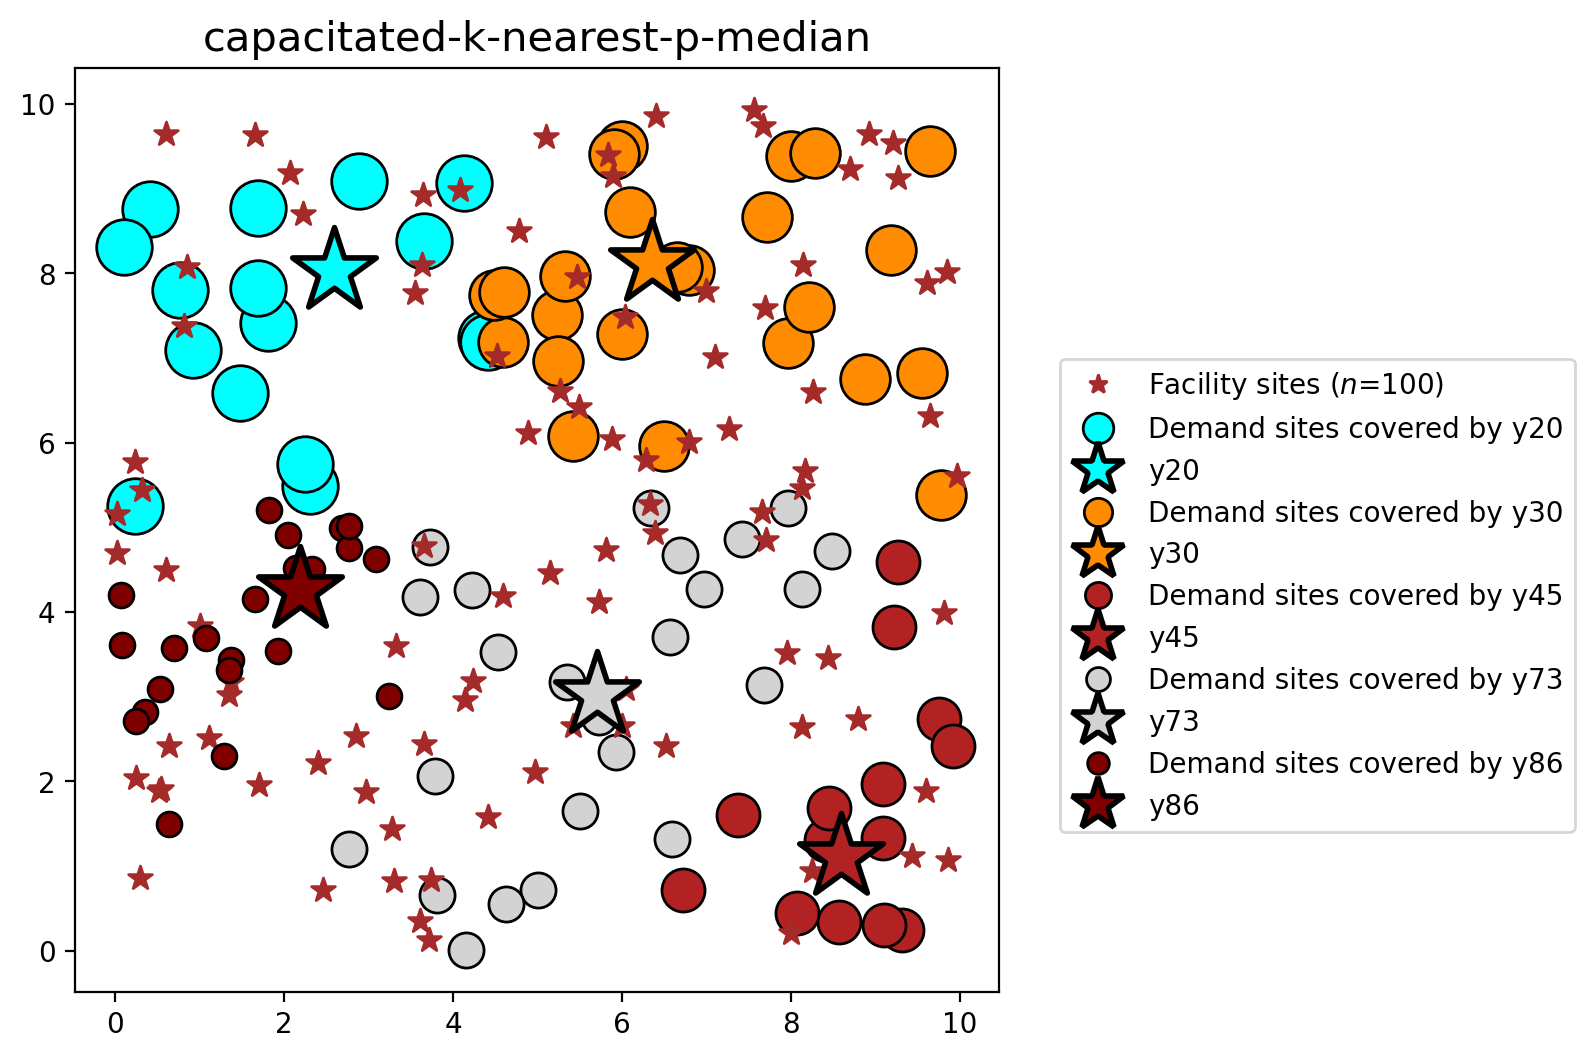

In [31]:
plot_results(pmedian_k_nearest_capacity, P_FAC, facilities, clis=clients)

-----------------------

## 6. Comparing variant results

### Solution diagnostics & optimal facility selection

Below we can see that:

* The classic $p$-median and $k$-nearest variant result in equivalent objective values and facility selections. However, the $k$-nearest variant achieves optimality from a formulation with approximately 15% the number of variables and constraints of the classic formulation, resulting in a dramatically reduced solution time.
* Similar results are observed with the capacitated variants: equivalent objective values and facility selections, plus solve times approximately 20% faster.
* **Caveat**: The solve times for the $k$-nearest variants do not include preparation of the minimal formulation, *only actual solve time* reported via `pulp`.

In [32]:
diagnostic

,model,variables,constraints,obj_val,selected,cpu_time,wall_time
0,classic-p-median,10100,10101,906.299,"[y25, y32, y34, y68, y86]",0.510654,0.921897
1,capacitated-p-median,10100,10201,962.151,"[y20, y30, y45, y73, y86]",11.699106,12.895250
2,k-nearest-p-median,1598,1499,906.299,"[y25, y32, y34, y68, y86]",0.064253,0.113859
3,capacitated-k-nearest-p-median,2045,3791,962.151,"[y20, y30, y45, y73, y86]",2.610536,2.998628


In [33]:
facilities.loc[(facilities[perc_cols] > 0).any(axis=1)]

,geometry,dv,capacity,pmp_classic,pmp_capacitated,pmp_k-nearest,pmp_k-nearest_capacitated
20,POINT (2.59098 8.02497),y20,121,0.0,83.0,0.0,83.0
25,POINT (7.70854 4.84931),y25,88,100.0,0.0,100.0,0.0
30,POINT (6.35356 8.11902),y30,153,0.0,100.0,0.0,100.0
32,POINT (8.24811 0.94203),y32,33,100.0,0.0,100.0,0.0
34,POINT (5.46358 7.96143),y34,140,100.0,0.0,100.0,0.0
45,POINT (8.59707 1.11111),y45,101,0.0,95.0,0.0,95.0
68,POINT (0.85070 8.07777),y68,82,100.0,0.0,100.0,0.0
73,POINT (5.70975 3.02518),y73,187,0.0,68.0,0.0,68.0
86,POINT (2.18498 4.25637),y86,102,100.0,100.0,100.0,100.0


-----------------------

## 7. References

- [Hakimi, S. L. (1965). Optimum Distribution of Switching Centers in a Communication Network and Some Related Graph Theoretic Problems. Operations Research, 13(3), 462–475.](https://doi:10.1287/opre.13.3.462) 
- [Church, R. L., & Murray, A. T. (2009). Business site selection, location analysis, and GIS (pp. 209-233). Hoboken, NJ: John Wiley & Sons.](http://ndl.ethernet.edu.et/bitstream/123456789/22145/1/45.pdf)
- [Church, R. L. (2018). Tobler’s Law and Spatial Optimization: Why Bakersfield? International Regional Science Review, 41(3), 287–310.](https://doi.org/10.1177/0160017616650612)
- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)

----------------